Importing Python Libraries and preparing the environment

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 22.6 MB/s 
     |████████████████████████████████| 6.6 MB 43.3 MB/s 
     |████████████████████████████████| 120 kB 14.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! ls /content/drive/My\ Drive/

Mounted at /content/drive
 2UntitledBERT.ipynb   full_documents_IOB_POS3150.csv   test-submit.txt
 bert_ner.pt	       glove.6B.50d.txt		        test.txt
'Colab Notebooks'      ITDataset715012050.csv	        train.txt
 data		       ITDataset7150120.csv
 dev.txt	       ner_datasetreference.csv


In [ ]:
!pip3 install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9062e4dac04b07cdd1422e417a72a8878bd59700f0e47fbc2e2952d352cee6ae
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
import os
import time
import numpy as np
from tqdm import tqdm, trange
import codecs
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

print(transformers.__version__)
print(torch.__version__) 

4.21.2
1.12.1+cu113


Setting the path of dataset

In [ ]:
data_path = '/content/drive/My Drive/data/'

fnames = os.listdir(data_path)
fnames.sort()
print(fnames)

data_files = []
for f in fnames:
    data_files.append(os.path.join(data_path, f))
print(data_files)

['dev.txt', 'test.txt', 'train.txt']
['/content/drive/My Drive/data/dev.txt', '/content/drive/My Drive/data/test.txt', '/content/drive/My Drive/data/train.txt']


In [ ]:
word_count = {}
tag_count = {}
word_train = []
train_tag = []
word_val = []
val_tag = []
word_test = []
test_tag = []
corpus_dic = {'word_test': word_test, 'test_tag': test_tag, 
              'word_val': word_val, 'val_tag': val_tag, 
              'word_train': word_train, 'train_tag': train_tag}
corpus_list = ['word_test', 'test_tag', 'word_train', 
               'train_tag', 'word_val', 'val_tag']
corpus_dic

{'word_test': [],
 'test_tag': [],
 'word_val': [],
 'val_tag': [],
 'word_train': [],
 'train_tag': []}

In [ ]:
for i, f in enumerate(data_files):
    with codecs.open(f, encoding='utf-8') as fid:
        for l in fid:
            if l == '\r\n' or l == '\n': continue
                
            l = l.replace('\r\n', '')
            t = l.split()
            corpus_dic[corpus_list[2*i]].append(t[0])
            corpus_dic[corpus_list[2*i+1]].append(t[1])

In [ ]:
for i in range(len(data_files)):
    for w in corpus_dic[corpus_list[2*i]]:
        if w in word_count:
            word_count[w] += 1
        else:
            word_count[w] = 1
    
    for t in corpus_dic[corpus_list[2*i+1]]:
        if t in tag_count:
            tag_count[t] += 1
        else:
            tag_count[t] = 1

In [ ]:
tag_count

{'-X-': 150,
 'NN': 14489,
 'WRB': 48,
 'TO': 885,
 'DT': 1560,
 '.': 1054,
 'PRP$': 181,
 'RB': 565,
 'IN': 3504,
 'MD': 231,
 'VBG': 1444,
 'CD': 341,
 ':': 1058,
 'JJ': 2502,
 ',': 2122,
 'WDT': 11,
 'PRP': 418,
 'CC': 2632,
 'VB': 750,
 'VBN': 575,
 'NNS': 4462,
 '(': 340,
 ')': 337,
 'NNP': 379,
 'VBZ': 177,
 'WP': 74,
 'VBP': 99,
 'VBD': 22,
 'JJS': 83,
 'POS': 54,
 'FW': 1,
 'JJR': 9,
 'SYM': 21,
 '#': 64,
 '$': 6,
 'RBR': 21}

In [ ]:
print(tag_count.values)

<built-in method values of dict object at 0x7f6ec5b0dd20>


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

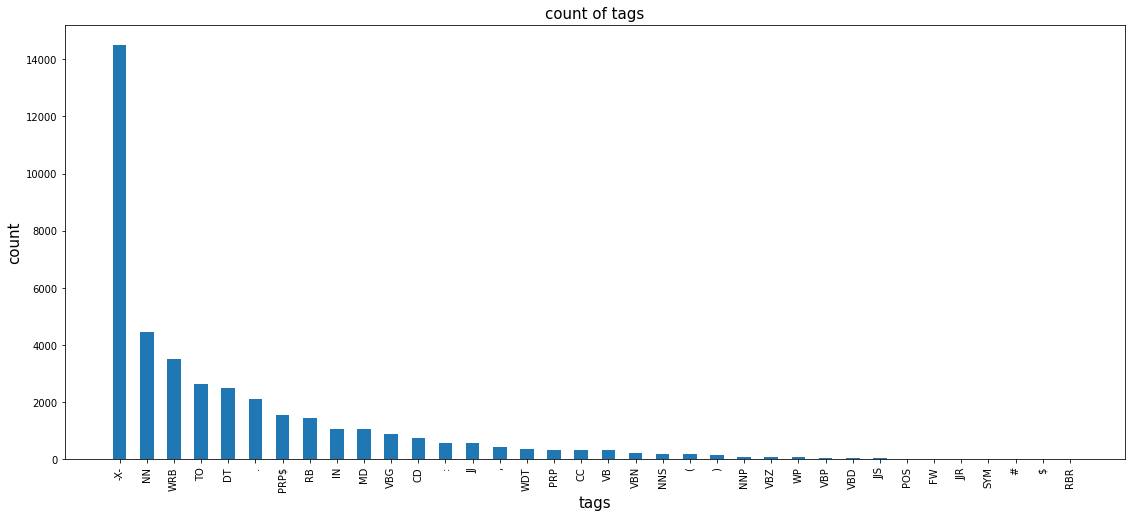

In [ ]:
plt.figure(figsize=[19, 8])
plt.bar(tag_count.keys(), sorted(tag_count.values(),reverse = True), width=0.5)

plt.title('count of tags', fontsize=15)
plt.xlabel('tags', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
wcounts = list(word_count.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
word_sorted = [w[0] for w in wcounts]
word_index = dict(list(zip(word_sorted, list(range(1, len(word_count) + 1)))))
word_index['PAD'] = 0
word_index['UNK'] = len(word_index)


Generate a dictionary of tags

In [ ]:
tag_index = {t[0]: i for i, t in enumerate(list(tag_count.items()))}
index_tag = {i: t[0] for i, t in enumerate(list(tag_count.items()))}

Insert PAD label into the dictionary

In [ ]:
tag_index['PAD'] = len(tag_count)
index_tag[len(tag_count)] = 'PAD'

In [ ]:
index_tag

{0: '-X-',
 1: 'NN',
 2: 'WRB',
 3: 'TO',
 4: 'DT',
 5: '.',
 6: 'PRP$',
 7: 'RB',
 8: 'IN',
 9: 'MD',
 10: 'VBG',
 11: 'CD',
 12: ':',
 13: 'JJ',
 14: ',',
 15: 'WDT',
 16: 'PRP',
 17: 'CC',
 18: 'VB',
 19: 'VBN',
 20: 'NNS',
 21: '(',
 22: ')',
 23: 'NNP',
 24: 'VBZ',
 25: 'WP',
 26: 'VBP',
 27: 'VBD',
 28: 'JJS',
 29: 'POS',
 30: 'FW',
 31: 'JJR',
 32: 'SYM',
 33: '#',
 34: '$',
 35: 'RBR',
 36: 'PAD'}

In [ ]:
tag_index

{'-X-': 0,
 'NN': 1,
 'WRB': 2,
 'TO': 3,
 'DT': 4,
 '.': 5,
 'PRP$': 6,
 'RB': 7,
 'IN': 8,
 'MD': 9,
 'VBG': 10,
 'CD': 11,
 ':': 12,
 'JJ': 13,
 ',': 14,
 'WDT': 15,
 'PRP': 16,
 'CC': 17,
 'VB': 18,
 'VBN': 19,
 'NNS': 20,
 '(': 21,
 ')': 22,
 'NNP': 23,
 'VBZ': 24,
 'WP': 25,
 'VBP': 26,
 'VBD': 27,
 'JJS': 28,
 'POS': 29,
 'FW': 30,
 'JJR': 31,
 'SYM': 32,
 '#': 33,
 '$': 34,
 'RBR': 35,
 'PAD': 36}

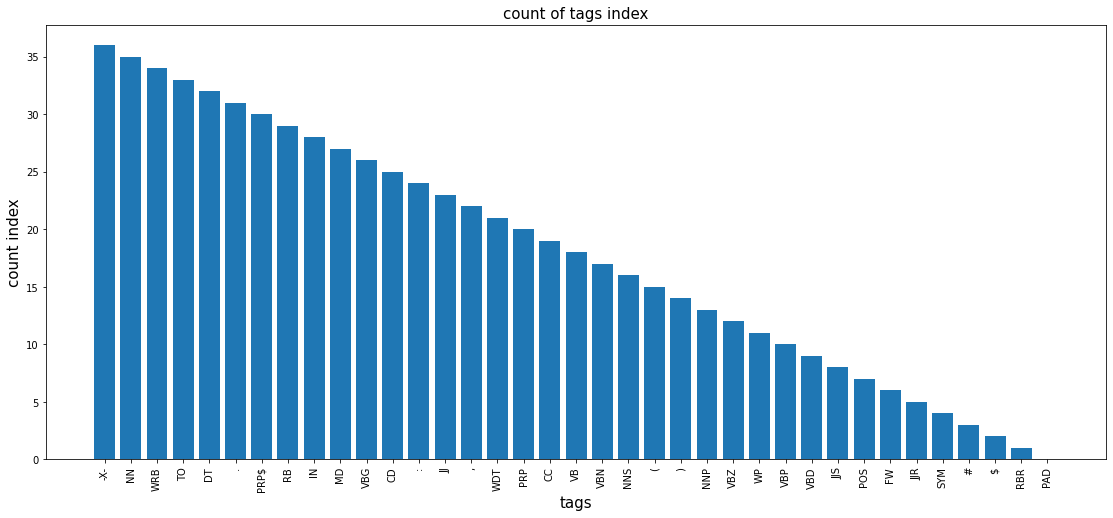

In [ ]:
plt.figure(figsize=[19, 8])
plt.bar(tag_index.keys(), sorted(tag_index.values(),reverse = True))

plt.title('count of tags index', fontsize=15)
plt.xlabel('tags', fontsize=15)
plt.ylabel('count index', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_sent = []
train_tag = []
val_sent = []
val_tag = []
test_sent = []
test_tag = []
sentences_corpus = {'test_sent': test_sent, 'test_tag': test_tag, 
                    'val_sent': val_sent, 'val_tag': val_tag, 
                    'train_sent': train_sent, 'train_tag': train_tag}
sent_corpus_list = ['test_sent', 'test_tag', 
                    'train_sent', 'train_tag',
                    'val_sent', 'val_tag']
sentences_corpus

{'test_sent': [],
 'test_tag': [],
 'val_sent': [],
 'val_tag': [],
 'train_sent': [],
 'train_tag': []}

Read all three datasets into a list of lists

In [ ]:
for i, f in enumerate(data_files):
    sent = []
    tag = []
    for l in open(f):
        if l in ['\n', '\r\n']:
            sentences_corpus[sent_corpus_list[2*i]].append(sent)
            sentences_corpus[sent_corpus_list[2*i+1]].append(tag)
            sent = []
            tag = []
        else:
            t = l.replace('\r\n', '').split()
            sent.append(t[0])
            tag.append(t[1])

In [ ]:
sentences_corpus[sent_corpus_list[2]]

[['-DOCSTART-', 'BI', '/', 'ANALYTICAL', 'FUNCTIONAL', 'ANALYST'],
 ['Alithya', 'Group', 'inc'],
 ['Tangier'],
 ['Responsibilities', ':'],
 ['•',
  'Participate',
  'in',
  'the',
  'development',
  'of',
  'prototypes',
  'and',
  'proofs',
  'of',
  'concept',
  'throughout',
  'the',
  'information',
  'product',
  'development',
  'life',
  'cycle',
  ';'],
 ['•',
  'Identify',
  ',',
  'analyze',
  ',',
  'and',
  'interpret',
  'trends',
  'and',
  'patterns',
  'in',
  'data',
  'sets',
  ',',
  'with',
  'data',
  'profiling',
  'techniques',
  ';'],
 ['•',
  'On',
  'a',
  'daily',
  'basis',
  'in',
  'agile',
  'mode',
  ',',
  'support',
  'the',
  'development',
  'team',
  'by',
  'defining',
  'and',
  'refining',
  'the',
  'specifications',
  'of',
  'the',
  'features',
  'to',
  'be',
  'developed',
  ';'],
 ['•',
  'Apply',
  'data',
  'modelling',
  'principles',
  'to',
  'support',
  'business',
  'requirements',
  ';'],
 ['•',
  'Define',
  'test',
  'strategies

In [ ]:
MAX_LEN = 150
batch_size = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load the pretrained English BERT tokenizer model from PyTorch Hub

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Tokenize every word into word pieces and clone the tag according to the number of word pieces

In [ ]:
def tokenize_and_preserve_tags(sentence, sent_tags):
    tokenized_sentence = []
    tags = []
    n_tokens = []

    for w, t in zip(sentence, sent_tags):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(w)
        n_subwords = len(tokenized_word)
        n_tokens.append(n_subwords)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels b`n_subwords` times
        tags.extend([t] * n_subwords)

    return tokenized_sentence, tags, n_tokens

Tokenize the training dataset

In [ ]:
train_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['train_sent'], sentences_corpus['train_tag'])
]

In [ ]:
print(train_tokenized_sents_and_tags[4])

(['•', 'Part', '##ici', '##pate', 'in', 'the', 'development', 'of', 'prototypes', 'and', 'proof', '##s', 'of', 'concept', 'throughout', 'the', 'information', 'product', 'development', 'life', 'cycle', ';'], ['NN', 'VB', 'VB', 'VB', 'IN', 'DT', 'NN', 'IN', 'NNS', 'CC', 'NN', 'NN', 'IN', 'NN', 'IN', 'DT', 'NN', 'NN', 'NN', 'NN', 'NN', ':'], [1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Split the training dataset into texts, labels and number of tokens of every word

In [ ]:
train_tokenized_texts = [token_label_pair[0] for token_label_pair in train_tokenized_sents_and_tags]
train_labels = [token_label_pair[1] for token_label_pair in train_tokenized_sents_and_tags]
num_tokens = [token_label_pair[2] for token_label_pair in train_tokenized_sents_and_tags]

In [ ]:
print(train_tokenized_texts[3])
print(train_labels[3])
print(num_tokens[3])

['Re', '##sp', '##ons', '##ibi', '##lities', ':']
['NNS', 'NNS', 'NNS', 'NNS', 'NNS', ':']
[5, 1]


In [ ]:
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
train_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
print(train_tokenized_texts[4])
print(train_input_ids[4])
print(train_tags[4])

['•', 'Part', '##ici', '##pate', 'in', 'the', 'development', 'of', 'prototypes', 'and', 'proof', '##s', 'of', 'concept', 'throughout', 'the', 'information', 'product', 'development', 'life', 'cycle', ';']
[  794  4539 27989 16963  1107  1103  1718  1104 22544  1105  6777  1116
  1104  3400  2032  1103  1869  3317  1718  1297  5120   132     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     

Generate masks for every input sequence to mask the inserted PAD(0) tokens

In [ ]:
train_attention_masks = [[float(i != 0.0) for i in ii] for ii in train_input_ids]
print(train_attention_masks[4])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Load and pre-process the validation dataset

In [ ]:
val_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['val_sent'], sentences_corpus['val_tag'])
]

In [ ]:
val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_sents_and_tags]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_sents_and_tags]

In [ ]:
val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")
val_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]

In [ ]:
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
train_tags = torch.tensor(train_tags)
val_tags = torch.tensor(val_tags)
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)

In [ ]:
training_data = TensorDataset(train_inputs, train_masks, train_tags)
training_sampler = RandomSampler(training_data)
training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [ ]:
training_data[4]

(tensor([  794,  4539, 27989, 16963,  1107,  1103,  1718,  1104, 22544,  1105,
          6777,  1116,  1104,  3400,  2032,  1103,  1869,  3317,  1718,  1297,
          5120,   132,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Load the pretrained English BERT model for token classification from PyTorch Hub

In [ ]:
ner_model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag_index),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
ner_model.cpu();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(ner_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(ner_model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 15
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(training_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
tick1 = time.time()
localtime = time.asctime(time.localtime(time.time()))
print( localtime)

Tue Aug 30 23:30:55 2022


In [ ]:
ner_model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):


    ner_model.train()
    total_loss = 0

    # Training loop
    for step, batch in enumerate(training_dataloader):
        # add batch to device (gpu or cpu)
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # reset gradients before performing a backward pass.
        ner_model.zero_grad()
        # forward pass, get the training loss
        outputs = ner_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the training loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        total_loss += loss.item()
        # Clip the norm of the gradient to prevent from the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=ner_model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(training_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================

    # Set the ner model to evaluation mode
    ner_model.eval()
    # Reset the validation loss
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Don't need to compute gradients
        with torch.no_grad():
            # Forward pass, calculate the predicted logits
            outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    
    pred_tags = []
    valid_tags = []
    for p, l in zip(predictions, true_labels):
        preds = []
        labs = []
        for p_i, l_i in zip(p, l):
            if index_tag[l_i] != "PAD":
                preds.append(index_tag[p_i])
                labs.append(index_tag[l_i])
        pred_tags.append(preds)
        valid_tags.append(labs)
    
    print("Validation Precision: {}".format(precision_score(valid_tags, pred_tags)))
    print("Validation Recall: {}".format(recall_score(valid_tags, pred_tags)))
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
    print("Report: {}".format(classification_report(valid_tags, pred_tags)))
    print()

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Average train loss: 0.8141793557084523
Validation loss: 0.27533926985093526


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: -X- seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: : seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NNP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VBG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

Validation Precision: 0.0021032951624211263
Validation Recall: 0.000492988606485539
Validation Accuracy: 0.3420583190394511
Validation F1-Score: 0.0007987574883514532


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   7%|▋         | 1/15 [00:42<09:57, 42.71s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.00      0.00      0.00       737
          BD       0.00      0.00      0.00        11
          BG       0.00      0.00      0.00       863
          BN       0.00      0.00      0.00       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.00      0.00      0.00       112
           C       0.00      0.00      0.00      1488
           D       0.00      0.00      0.00       362
          DT       0.00      0.00      0.00         5
           J       0.00      0.00      0.00      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.00      0.00      0.00      6354
          NP       0.00      0.00      0.00       195
          NS       0.00      0.00      0.00      2455
           O       

Epoch:  13%|█▎        | 2/15 [01:25<09:12, 42.48s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.00      0.00      0.00       737
          BD       0.00      0.00      0.00        11
          BG       0.00      0.00      0.00       863
          BN       0.00      0.00      0.00       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.00      0.00      0.00       112
           C       0.35      0.01      0.01      1488
           D       0.00      0.00      0.00       362
          DT       0.00      0.00      0.00         5
           J       0.00      0.00      0.00      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.04      0.02      0.02      6354
          NP       0.00      0.00      0.00       195
          NS       0.00      0.00      0.00      2455
           O       

Epoch:  20%|██        | 3/15 [02:11<08:49, 44.14s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.00      0.00      0.00       737
          BD       0.00      0.00      0.00        11
          BG       0.00      0.00      0.00       863
          BN       0.00      0.00      0.00       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.00      0.00      0.00       112
           C       0.75      0.90      0.82      1488
           D       0.00      0.00      0.00       362
          DT       0.00      0.00      0.00         5
           J       0.00      0.00      0.00      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.27      0.25      0.26      6354
          NP       0.00      0.00      0.00       195
          NS       0.40      0.12      0.18      2455
           O       

Epoch:  27%|██▋       | 4/15 [02:56<08:09, 44.48s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.00      0.00      0.00       737
          BD       0.00      0.00      0.00        11
          BG       0.50      0.00      0.01       863
          BN       0.00      0.00      0.00       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.00      0.00      0.00       112
           C       0.96      0.94      0.95      1488
           D       0.00      0.00      0.00       362
          DT       0.00      0.00      0.00         5
           J       0.23      0.01      0.01      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.40      0.43      0.41      6354
          NP       0.00      0.00      0.00       195
          NS       0.80      0.63      0.70      2455
           O       

Epoch:  33%|███▎      | 5/15 [03:41<07:28, 44.88s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.30      0.06      0.10       737
          BD       0.00      0.00      0.00        11
          BG       0.53      0.11      0.18       863
          BN       0.00      0.00      0.00       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.00      0.00      0.00       112
           C       0.96      0.94      0.95      1488
           D       0.45      0.01      0.03       362
          DT       0.00      0.00      0.00         5
           J       0.39      0.22      0.28      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.50      0.58      0.54      6354
          NP       0.00      0.00      0.00       195
          NS       0.80      0.82      0.81      2455
           O       

Epoch:  40%|████      | 6/15 [04:27<06:45, 45.03s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.47      0.19      0.27       737
          BD       0.00      0.00      0.00        11
          BG       0.55      0.40      0.46       863
          BN       0.00      0.00      0.00       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.00      0.00      0.00       112
           C       0.99      0.94      0.96      1488
           D       0.52      0.15      0.24       362
          DT       0.00      0.00      0.00         5
           J       0.46      0.41      0.43      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.58      0.67      0.62      6354
          NP       0.00      0.00      0.00       195
          NS       0.81      0.86      0.83      2455
           O       

Epoch:  47%|████▋     | 7/15 [05:12<06:01, 45.18s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.44      0.29      0.35       737
          BD       0.00      0.00      0.00        11
          BG       0.66      0.53      0.58       863
          BN       0.67      0.01      0.01       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.96      0.24      0.39       112
           C       0.99      0.94      0.96      1488
           D       0.51      0.23      0.32       362
          DT       0.00      0.00      0.00         5
           J       0.52      0.53      0.52      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.63      0.72      0.67      6354
          NP       0.00      0.00      0.00       195
          NS       0.85      0.88      0.86      2455
           O       

Epoch:  53%|█████▎    | 8/15 [05:58<05:17, 45.35s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.52      0.39      0.44       737
          BD       0.00      0.00      0.00        11
          BG       0.68      0.71      0.69       863
          BN       0.75      0.03      0.06       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.92      0.44      0.59       112
           C       0.98      0.95      0.97      1488
           D       0.58      0.34      0.43       362
          DT       0.00      0.00      0.00         5
           J       0.54      0.63      0.58      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.68      0.76      0.71      6354
          NP       0.00      0.00      0.00       195
          NS       0.85      0.90      0.87      2455
           O       

Epoch:  60%|██████    | 9/15 [06:44<04:33, 45.53s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.52      0.46      0.49       737
          BD       0.00      0.00      0.00        11
          BG       0.72      0.72      0.72       863
          BN       0.65      0.07      0.13       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.83      0.71      0.77       112
           C       0.99      0.96      0.97      1488
           D       0.65      0.39      0.49       362
          DT       0.00      0.00      0.00         5
           J       0.55      0.67      0.60      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.70      0.78      0.74      6354
          NP       0.00      0.00      0.00       195
          NS       0.86      0.90      0.88      2455
           O       

Epoch:  67%|██████▋   | 10/15 [07:29<03:48, 45.62s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.58      0.51      0.54       737
          BD       0.00      0.00      0.00        11
          BG       0.75      0.76      0.76       863
          BN       0.74      0.24      0.36       309
          BP       0.00      0.00      0.00        65
          BR       0.00      0.00      0.00        16
          BZ       0.81      0.76      0.78       112
           C       0.98      0.98      0.98      1488
           D       0.68      0.46      0.55       362
          DT       0.00      0.00      0.00         5
           J       0.56      0.75      0.64      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.74      0.79      0.76      6354
          NP       0.00      0.00      0.00       195
          NS       0.87      0.92      0.89      2455
           O       

Epoch:  73%|███████▎  | 11/15 [08:15<03:02, 45.64s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.60      0.51      0.55       737
          BD       0.00      0.00      0.00        11
          BG       0.76      0.79      0.78       863
          BN       0.75      0.19      0.31       309
          BP       1.00      0.02      0.03        65
          BR       0.00      0.00      0.00        16
          BZ       0.80      0.80      0.80       112
           C       0.98      0.98      0.98      1488
           D       0.71      0.47      0.56       362
          DT       0.00      0.00      0.00         5
           J       0.57      0.76      0.65      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.75      0.80      0.77      6354
          NP       0.00      0.00      0.00       195
          NS       0.88      0.91      0.89      2455
           O       

Epoch:  80%|████████  | 12/15 [09:01<02:17, 45.68s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.63      0.55      0.59       737
          BD       0.00      0.00      0.00        11
          BG       0.79      0.78      0.79       863
          BN       0.75      0.37      0.49       309
          BP       1.00      0.03      0.06        65
          BR       0.00      0.00      0.00        16
          BZ       0.79      0.83      0.81       112
           C       0.97      0.98      0.98      1488
           D       0.69      0.48      0.57       362
          DT       0.00      0.00      0.00         5
           J       0.63      0.74      0.68      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.75      0.81      0.78      6354
          NP       0.00      0.00      0.00       195
          NS       0.88      0.92      0.90      2455
           O       

Epoch:  87%|████████▋ | 13/15 [09:47<01:31, 45.68s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.59      0.58      0.59       737
          BD       0.00      0.00      0.00        11
          BG       0.81      0.81      0.81       863
          BN       0.74      0.41      0.53       309
          BP       1.00      0.03      0.06        65
          BR       0.00      0.00      0.00        16
          BZ       0.78      0.83      0.80       112
           C       0.98      0.99      0.98      1488
           D       0.69      0.50      0.58       362
          DT       0.00      0.00      0.00         5
           J       0.63      0.78      0.70      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.76      0.81      0.78      6354
          NP       1.00      0.01      0.02       195
          NS       0.89      0.92      0.90      2455
           O       

Epoch:  93%|█████████▎| 14/15 [10:32<00:45, 45.67s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.64      0.58      0.61       737
          BD       0.00      0.00      0.00        11
          BG       0.81      0.81      0.81       863
          BN       0.73      0.39      0.51       309
          BP       1.00      0.03      0.06        65
          BR       0.00      0.00      0.00        16
          BZ       0.77      0.84      0.80       112
           C       0.98      0.99      0.98      1488
           D       0.69      0.49      0.58       362
          DT       0.00      0.00      0.00         5
           J       0.63      0.80      0.70      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.77      0.82      0.79      6354
          NP       1.00      0.01      0.02       195
          NS       0.89      0.93      0.91      2455
           O       

Epoch: 100%|██████████| 15/15 [11:18<00:00, 45.23s/it]

Report:               precision    recall  f1-score   support

          AD       0.00      0.00      0.00         0
           B       0.63      0.58      0.61       737
          BD       0.00      0.00      0.00        11
          BG       0.82      0.81      0.82       863
          BN       0.73      0.40      0.52       309
          BP       1.00      0.03      0.06        65
          BR       0.00      0.00      0.00        16
          BZ       0.77      0.85      0.81       112
           C       0.98      0.99      0.98      1488
           D       0.68      0.50      0.58       362
          DT       0.00      0.00      0.00         5
           J       0.64      0.79      0.71      1381
          JR       0.00      0.00      0.00         4
          JS       0.00      0.00      0.00        54
           N       0.77      0.81      0.79      6354
          NP       1.00      0.01      0.02       195
          NS       0.89      0.92      0.90      2455
           O       

In [ ]:
localtime = time.asctime(time.localtime(time.time()))
print("l'heure de la fin est：", localtime)

tick2 = time.time()
print("Elapsed time: ", tick2 - tick1)
print(time.strftime("%H:%M:%S", time.localtime(tick2-tick1-3600*8)))

l'heure de la fin est： Tue Aug 30 23:42:20 2022
Elapsed time:  685.1176173686981
16:11:25


In [ ]:
ner_model.train()
torch.save(ner_model, '/content/drive/My Drive/bert_ner.pt')

In [ ]:
#ner_model = torch.load('bert_ner.pt', map_location=torch.device('cpu'))
ner_model = torch.load('/content/drive/My Drive/bert_ner.pt')
ner_model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

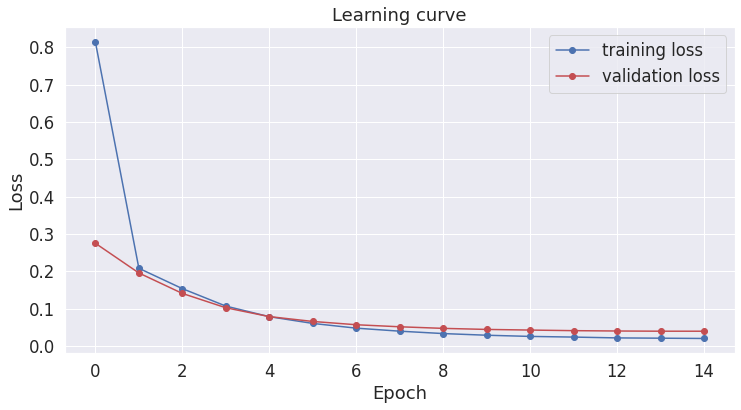

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
test_sentence = """Technical Support Engineer Dell Technologies Casablanca, for Responsibilities: installing, repairing devices, 
Use of existing ERP’s database developing several reports in order to establish and optimize several procedures. Competencies:Degree Required 
on IT with minimum 5 years experience Native speaking in French and fluent in English Advanced experience with Office Tools."""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cpu()
#input_ids = torch.tensor([tokenized_sentence])

with torch.no_grad():
    output = ner_model(input_ids.cuda())
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(index_tag[label_idx])
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

PAD	[CLS]
JJ	Technical
NN	Support
NN	Engineer
PAD	Dell
NNS	Technologies
PAD	Casablanca
,	,
IN	for
NNS	Responsibilities
:	:
VBG	installing
,	,
VBG	repairing
NNS	devices
,	,
NN	Use
IN	of
VBG	existing
NN	ERP
NN	’
NN	s
NN	database
VBG	developing
JJ	several
NNS	reports
IN	in
NN	order
TO	to
NN	establish
CC	and
NN	optimize
JJ	several
NNS	procedures
.	.
NNS	Competencies
:	:
NN	Degree
JJ	Required
IN	on
NN	IT
IN	with
NN	minimum
CD	5
NNS	years
NN	experience
PAD	Native
VBG	speaking
IN	in
JJ	French
CC	and
VBG	fluent
IN	in
JJ	English
JJ	Advanced
NN	experience
IN	with
NN	Office
NNS	Tools
.	.
NN	[SEP]


In [ ]:
test_tokenized_sents_and_tags = [
    tokenize_and_preserve_tags(sent, tag)
    for sent, tag in zip(sentences_corpus['test_sent'], sentences_corpus['test_tag'])
]

In [ ]:
test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_sents_and_tags]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_sents_and_tags]
num_tokens = [token_label_pair[2] for token_label_pair in test_tokenized_sents_and_tags]

In [ ]:
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
test_tags = pad_sequences([[tag_index.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag_index["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]
#print(test_attention_masks[3])

In [ ]:
test_inputs = torch.tensor(test_input_ids)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_attention_masks)

In [ ]:
test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
%%time

test_pred_tags, test_predictions = [], []
test_true_labels, test_token_ids, test_input_tokens = [], [], []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate the predicted logits
        outputs = ner_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)#, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    token_ids = b_input_ids.to('cpu').numpy()
    
    test_predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    test_true_labels.extend(label_ids)
    test_token_ids.extend(token_ids)
    
for p, l in zip(test_predictions, test_true_labels):
    preds = []
    labs = []
    for p_i, l_i in zip(p, l):
        if index_tag[l_i] != "PAD":
            preds.append(index_tag[p_i])                
    test_pred_tags.append(preds)
    
for ids in test_token_ids:
    token = []
    for t in ids:
        if t != 0:
            token.append(t)    
    test_input_tokens.append(tokenizer.convert_ids_to_tokens(token))

CPU times: user 9.22 s, sys: 57.7 ms, total: 9.28 s
Wall time: 9.32 s


In [ ]:
new_tokens, new_tags = [], []
for tokens, tags in zip(test_input_tokens, test_pred_tags):
    new_tok, new_t = [], []
    for t, tag in zip(tokens, tags):
        if t.startswith("##"):
            new_tok[-1] = new_tok[-1] + t[2:]
        else:
            new_t.append(tag)
            new_tok.append(t)
    new_tokens.append(new_tok)
    new_tags.append(new_t)

In [ ]:
pred_tags = []
for i in test_pred_tags:
    pred_tags.extend(i)
#pred_tags

In [ ]:
n_token = []
for i in num_tokens:
    n_token.extend(i)
#n_token

Save the predicted named entities to test-submit.txt

In [ ]:
%%time

submit = '/content/drive/My Drive/test-submit.txt'
test = '/content/drive/My Drive/data/test.txt'
fid2 = open(submit, 'w', encoding='UTF-8')
i = 0
j = 0
with codecs.open(test, encoding='utf-8') as fid:
    for l in fid:
        if l == '\r\n' or l == '\n': 
            print(l, end='')
            fid2.write(l)
        else:
            l = l.replace('\r\n', '')
            line = l.rstrip()[:-1]+pred_tags[i]+'\n'
            i = i + n_token[j]
            j = j + 1
            print(line, end='')
            fid2.write(line)
fid2.close()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
are	VBP	NNS
valuable	JJ	TO

and	CC	NN
important	JJ	CC
.	.	NN
-DOCSTART- -X- O JJ
Senior	JJ	B-PROFILNNS
Associate	NN	I-PROFILNN
-	:	I-PROFILIN
ESG	NN	I-PROFILNN
Analytics	NNS	I-PROFILNN

ZM	NN	B-COMPANNN
Financial	JJ	I-COMPAN(
Systems	NNS	I-COMPANNN

Rabat	NN	B-LOCATIONN

Responsibilities	NNS	NN
:	:	NN

Act	NNP	JJ
as	IN	NN
subject	NN	NN
-	:	)
matter	NN	NN
expert	NN	NN
across	IN	IN
all	DT	NN
sectors	NNS	VBZ
,	,	NNS
themes	NNS	IN
or	CC	NNS
industries	NNS	NN

covered	VBN	:
within	IN	NN
the	DT	IN
assigned	VBN	NN
research	NN	NN
line	NN	NN
,	,	NN
demonstrating	VBG	VBZ
advanced	JJ	DT
-	:	NNS
level	NN	IN

understanding	VBG	NN
of	IN	VBZ
the	DT	NN
methodology	NN	VB
,	,	NN
process	NN	IN
,	,	JJ
and	CC	NN
overall	JJ	(
research	NN	NN
framework	NN	)
;	:	IN

Spearheading	VBG	NN
innovative	JJ	IN
research	NN	IN
that	IN	NN
tracks	NNS	NN
the	DT	NN
evolving	VBG	NN
interaction	NN	NN

between	IN	NN
financial	JJ	NN
materiality	NN	VBZ